In [6]:
# importing libraries
import time
import joblib
import os
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf

from prototype.logstic_regression import Logistic_Regression
from prototype.XGBoost import XGBoost
from prototype.naive_bayes import Naive_Bayes
from prototype.rnn import RNN
from prototype.cnn import CNN
from prototype.bert import BERT
from prototype.bilstm import BiLSTM

# Load the TextPreprocessor class (assumed to be defined already)
from textpreprocessor_rev2 import TextPreprocessor

import warnings
warnings.filterwarnings("ignore")

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [7]:
NUM_SAMPLE = 10000
TEST_RATIO=0.2
BATCH_SIZE=16
EPOCHS = 2
MAX_WORD_COUNT = 5000
MAX_LENGTH = 100
OUTPUT_DIR = "Output/proto_models_rev2"

----------TRAIN DATA----------
before filter
Words count - 50%:  221
Words count - 70%:  323
Words count - 80%:  392


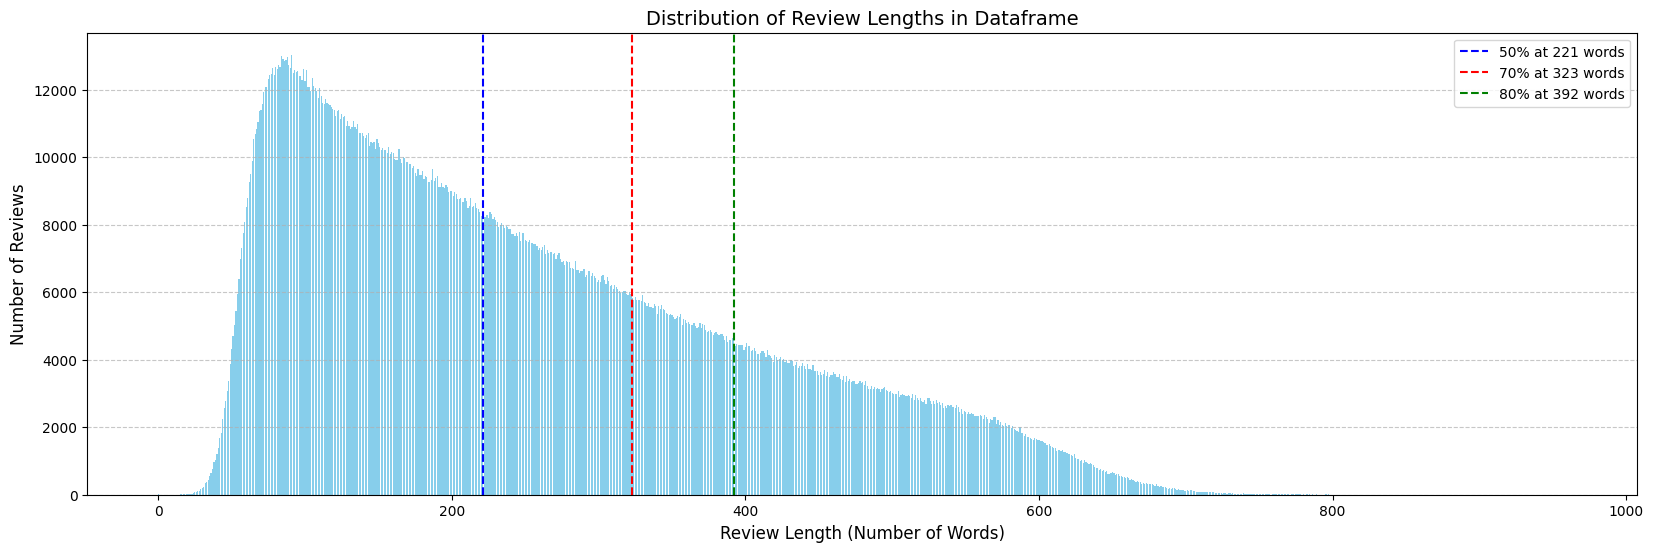

Max length: 222
after filter


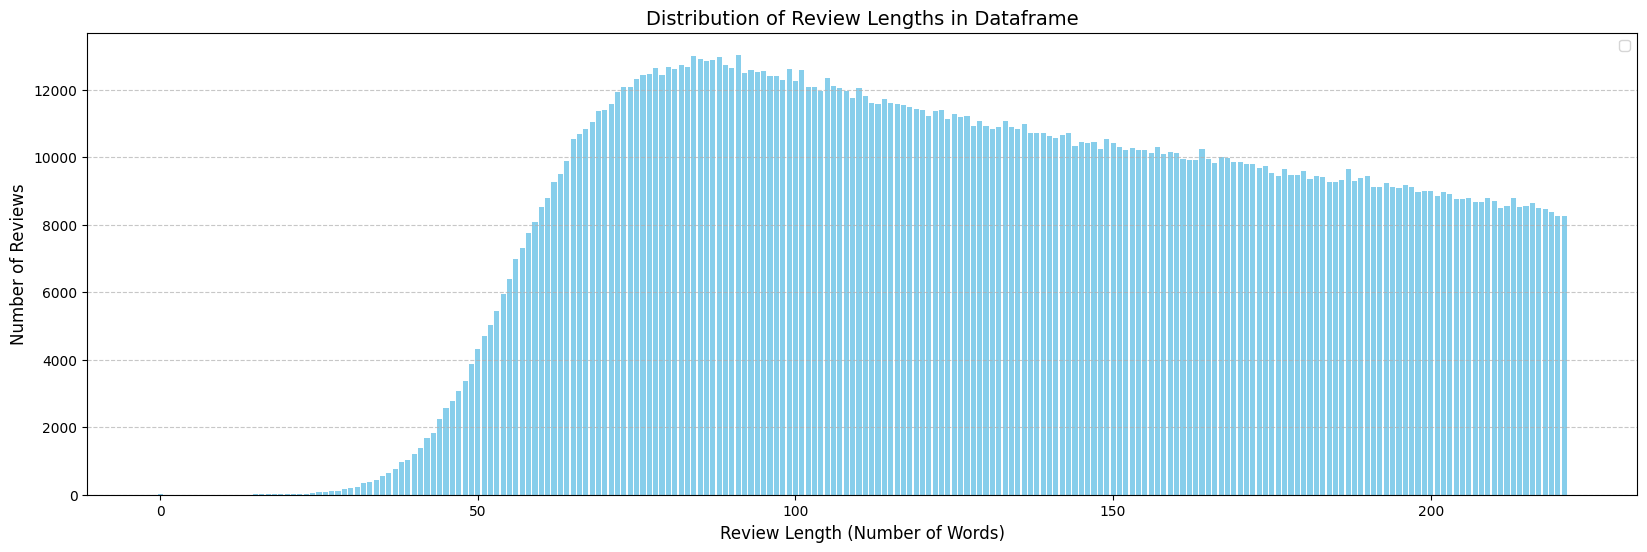

----------TEST DATA----------
before filter
Words count - 50%:  221
Words count - 70%:  323
Words count - 80%:  392


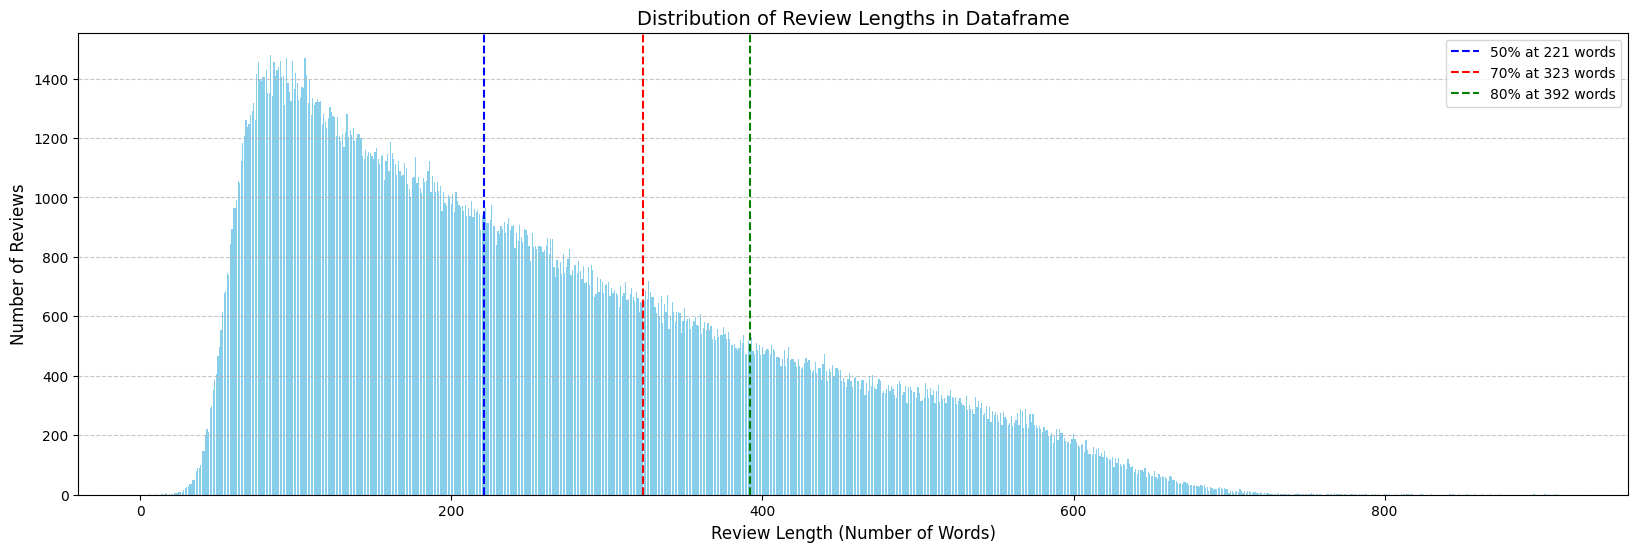

Max length: 222
after filter


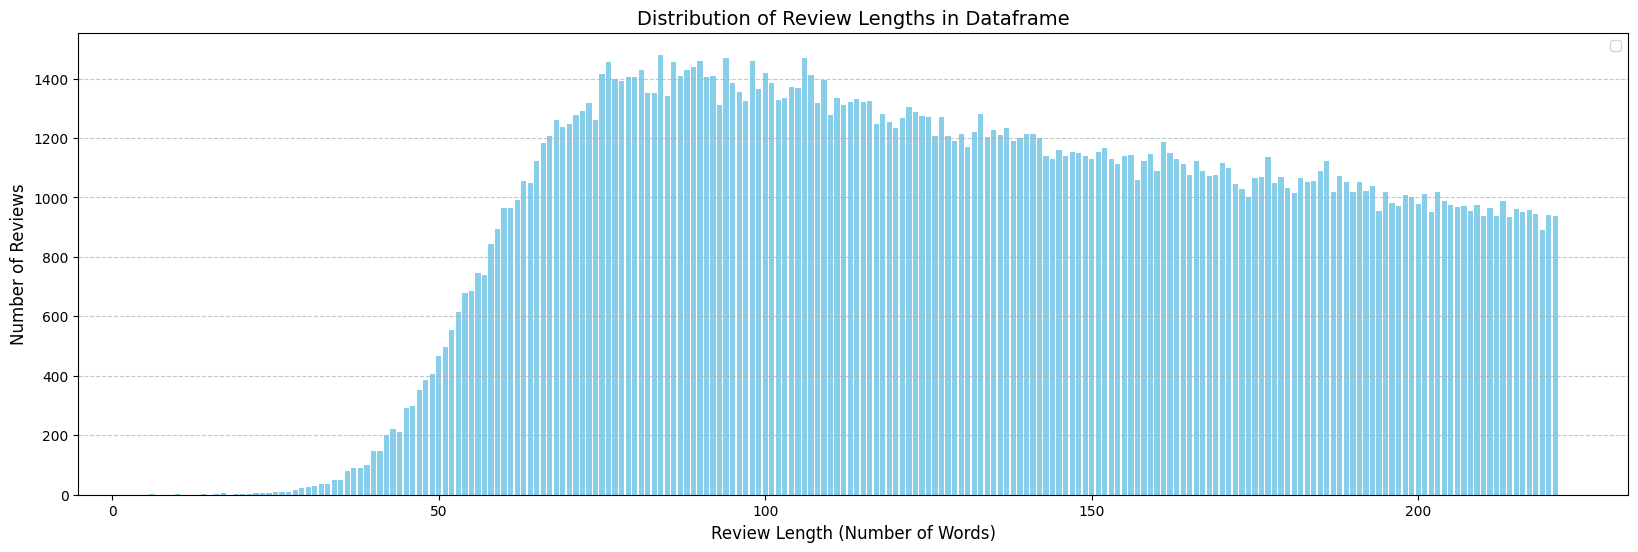

In [8]:
# Initialize the Text Preprocessor
processor = TextPreprocessor(MAX_WORD_COUNT, MAX_LENGTH)

# Load data
df_train, df_test = processor.parallel_load_data()

df_train_step1 = processor.remove_stopwords(df_train.copy())
df_test_step1 = processor.remove_stopwords(df_test.copy())

print('----------TRAIN DATA----------')
df_train_step2 = processor.filter_by_length_of_sentence(df_train_step1.copy(),50)
print('----------TEST DATA----------')
df_test_step2 = processor.filter_by_length_of_sentence(df_test_step1.copy(),50)

df_train_step3 = processor.sampling_data(df_train_step2, NUM_SAMPLE)
df_test_step3 = processor.sampling_data(df_test_step2, int(NUM_SAMPLE*TEST_RATIO))

# Preprocess data
df_train_step3 = processor.map_polarity(df_train_step3.copy())
df_test_step3 = processor.map_polarity(df_test_step3.copy())

# Split data
X_train, y_train = processor.split_data(df_train_step3)
X_test, y_test = processor.split_data(df_test_step3)

In [9]:
X_train_tfidf, X_test_tfidf = processor.vectorize_text(X_train, X_test)
X_train_pad, X_test_pad = processor.tokenization_and_padding(X_train, X_test)

01. Logistic Regression

In [10]:
logistic_regression = Logistic_Regression()
logistic_model = logistic_regression.train_model(X_train_tfidf, y_train)
y_pred_logistic = logistic_model.predict(X_test_tfidf)

02. XGBoost

In [11]:
xgboost = XGBoost()
xgb_model = xgboost.train_model(X_train_tfidf, y_train)

# Make predictions
y_pred_prob_xgb = xgb_model.predict(xgboost.convert_to_dmatrix(X_test_tfidf, y_test))
y_pred_xgb = [1 if prob > 0.5 else 0 for prob in y_pred_prob_xgb]

03. Naive Bayes

In [12]:
naive_bayes = Naive_Bayes()
nb_model = naive_bayes.train_model(X_train_tfidf, y_train)

# Making predictions
y_pred_nb = nb_model.predict(X_test_tfidf)

04. Recurrent Neural Network

In [13]:
rnn = RNN(processor.max_features, processor.max_length, EPOCHS, 32)
rnn_model = rnn.train_model(X_train_pad, y_train, X_test_pad, y_test)

# Evaluate the model
y_pred_prob = rnn_model.predict(X_test_pad)
y_pred_rnn = (y_pred_prob > 0.5).astype("int32")

Epoch 1/2


I0000 00:00:1728473956.305496     787 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728473956.305563     787 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728473956.305577     787 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728473956.323760     787 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728473956.323837     787 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-09

  5/313 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.5220 - loss: 0.7001

I0000 00:00:1728473957.524901   10047 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.6427 - loss: 0.6077 - val_accuracy: 0.8015 - val_loss: 0.4400
Epoch 2/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9115 - loss: 0.2339 - val_accuracy: 0.8130 - val_loss: 0.4694
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


05. Convolutional Neural Network

In [14]:
cnn = CNN(processor.max_features, processor.max_length, EPOCHS, 32)
cnn_model = cnn.train_model(X_train_pad, y_train, X_test_pad, y_test)

# Evaluate the model
y_pred_prob = rnn_model.predict(X_test_pad)
y_pred_cnn = (y_pred_prob > 0.5).astype("int32")

Epoch 1/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6868 - loss: 0.5627 - val_accuracy: 0.8295 - val_loss: 0.3784
Epoch 2/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9205 - loss: 0.2134 - val_accuracy: 0.8330 - val_loss: 0.4086
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


06. Bidirectional Encoder Representations from Transformers(BERT)

In [15]:
from tensorflow.keras import mixed_precision

# Mixed Precision 설정
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [16]:
bert = BERT(processor.max_features, 100, EPOCHS, int(32))
bert_model = bert.train_model(X_train, y_train, X_test, y_test)

# Predict on test data
y_pred_prob = bert_model.predict({'input_ids': bert.X_test_tokens['input_ids'], 'attention_mask': bert.X_test_tokens['attention_mask']}).logits
y_pred_bert = np.argmax(y_pred_prob, axis=-1)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
313/313 [==============================] - 86s 248ms/step - loss: 0.4107 - accuracy: 0.8080 - val_loss: 0.3263 - val_accuracy: 0.8545
Epoch 2/2
63/63 [==============================] - 6s 82ms/step


07. Bidirectional Long Short-Term Memory (BiLSTM)

In [17]:
X_train_tfidf, X_test_tfidf = processor.vectorize_text(X_train, X_test)
X_train_pad, X_test_pad = processor.tokenization_and_padding(X_train, X_test)

In [18]:
bilstm = BiLSTM(processor.tokenizer, EPOCHS, BATCH_SIZE)
bilstm_model = bilstm.train_model(X_train_pad, y_train, X_test_pad,y_test)

# Evaluate the model
y_pred_prob = bilstm_model.predict(X_test_pad)
y_pred_bilstm = (y_pred_prob > 0.5).astype("int32")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.7125 - loss: 0.5270 - val_accuracy: 0.8170 - val_loss: 0.3881
Epoch 2/2
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.8891 - loss: 0.2728 - val_accuracy: 0.8160 - val_loss: 0.4043
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [19]:
# Dictionary to store the results
results = {
    'Model': [],
    'Training-Time':[],
    'Accuracy': [],
    'Precision (Class 0)': [],
    'Precision (Class 1)': [],
    'Recall (Class 0)': [],
    'Recall (Class 1)': [],
    'F1-Score (Class 0)': [],
    'F1-Score (Class 1)': []
}

# Function to calculate accuracy and classification report
def evaluate_model(model_class, y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred) * 100
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Store the results
    results['Model'].append(model_class.model_name)
    results['Training-Time'].append(model_class.training_time)
    results['Accuracy'].append(accuracy)
    results['Precision (Class 0)'].append(report['0']['precision'])
    results['Precision (Class 1)'].append(report['1']['precision'])
    results['Recall (Class 0)'].append(report['0']['recall'])
    results['Recall (Class 1)'].append(report['1']['recall'])
    results['F1-Score (Class 0)'].append(report['0']['f1-score'])
    results['F1-Score (Class 1)'].append(report['1']['f1-score'])

# Call the function with your actual predictions (replace placeholders with your data)
evaluate_model(logistic_regression, y_test, y_pred_logistic)
evaluate_model(xgboost, y_test, y_pred_xgb)
evaluate_model(naive_bayes, y_test, y_pred_nb)
evaluate_model(rnn, y_test, y_pred_rnn)
evaluate_model(cnn, y_test, y_pred_cnn)
evaluate_model(bert, y_test, y_pred_bert)
evaluate_model(bilstm, y_test, y_pred_bilstm)

# Create a DataFrame from the results
df_results = pd.DataFrame(results)

# Create the directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Save result to an Excel file
df_results.to_excel(os.path.join(OUTPUT_DIR, f'result(epoch{EPOCHS}_batch{BATCH_SIZE}_sample{NUM_SAMPLE}_ratio{TEST_RATIO}).xlsx'), index=False)

In [20]:
df_results

,Model,Training-Time,Accuracy,Precision (Class 0),Precision (Class 1),Recall (Class 0),Recall (Class 1),F1-Score (Class 0),F1-Score (Class 1)
0,Logistic_Regression,0.024321,83.90,0.820426,0.853922,0.818589,0.855465,0.819507,0.854693
1,XGBoost,0.826344,78.80,0.758545,0.812443,0.770437,0.802168,0.764444,0.807273
2,Naive_Bayes,0.002842,81.95,0.827586,0.813973,0.752520,0.873532,0.788270,0.842702
3,RNN,30.425267,81.30,0.796571,0.825778,0.780515,0.839205,0.788462,0.832437
4,CNN,3.324620,81.30,0.796571,0.825778,0.780515,0.839205,0.788462,0.832437
5,BERT,162.082774,86.50,0.872162,0.859845,0.817469,0.903342,0.843931,0.881057
6,BiLSTM,28.700584,81.60,0.784399,0.843083,0.810750,0.820235,0.797357,0.831502


In [21]:
# Save Models
joblib.dump(logistic_model, os.path.join(OUTPUT_DIR, 'logistic_regression_model.pkl'))
joblib.dump(xgb_model, os.path.join(OUTPUT_DIR, 'xgboost_model.pkl'))
joblib.dump(nb_model, os.path.join(OUTPUT_DIR, 'naive_bayes_model.pkl'))
rnn_model.save(os.path.join(OUTPUT_DIR, 'rnn_model.h5'))  # or .tf
cnn_model.save(os.path.join(OUTPUT_DIR, 'cnn_model.h5'))
bert_model.save(os.path.join(OUTPUT_DIR, 'bert_model'), save_format='tf')
bilstm_model.save(os.path.join(OUTPUT_DIR, 'bilstm_model.h5'))

INFO:tensorflow:Assets written to: Output/proto_models_rev2/bert_model/assets


INFO:tensorflow:Assets written to: Output/proto_models_rev2/bert_model/assets


In [22]:
joblib.dump(processor.tokenizer, os.path.join(OUTPUT_DIR, 'processor_tokenizer.pkl'))
joblib.dump(bert.X_train_tokens, os.path.join(OUTPUT_DIR, 'bert_X_train_tokens.pkl'))
joblib.dump(bert.X_test_tokens, os.path.join(OUTPUT_DIR, 'bert_X_test_tokens.pkl'))

joblib.dump(X_train_tfidf, os.path.join(OUTPUT_DIR, 'X_train_tfidf.pkl'))
joblib.dump(X_test_tfidf, os.path.join(OUTPUT_DIR, 'X_test_tfidf.pkl'))

joblib.dump(X_train_pad, os.path.join(OUTPUT_DIR, 'X_train_pad.pkl'))
joblib.dump(X_test_pad, os.path.join(OUTPUT_DIR, 'X_test_pad.pkl'))

['Output/proto_models_rev2/X_test_pad.pkl']